# Approches semi-supervisées

Comparaison modèle supervisé simple et 

1. self-training : simple/itératif
2. propagation label
    

## Récupération des données

In [1]:
%matplotlib inline

In [4]:
%pip install -U numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 5.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 4.7 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.42.0
    Uninstalling llvmlite-0.42.0:
      Successfully uninstalled llvmlite-0.42.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
import umap
import sklearn
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pds

In [6]:
sklearn.__version__

'1.6.1'

In [7]:
sns.set(context="paper", style="white")

%time mnist = fetch_openml("mnist_784", version=1)#,return_X_y=True)

CPU times: user 3.11 s, sys: 2.61 s, total: 5.72 s
Wall time: 5.75 s


In [8]:
data = mnist.data
mnist["target"] = mnist["target"].astype(int)
target = mnist["target"]

# check que les données sont déjà mélangées
print(target.values[:10])

[5 0 4 1 9 2 1 3 1 4]


In [9]:
subset_ratio = 0.15 # on ne prend pas tout pour aller plus vite
train_ratio = 0.9  # on entraine sur % du subset
labelled_ratio = 0.1 # et on utilise qu'une partie des labels (semi-sup)

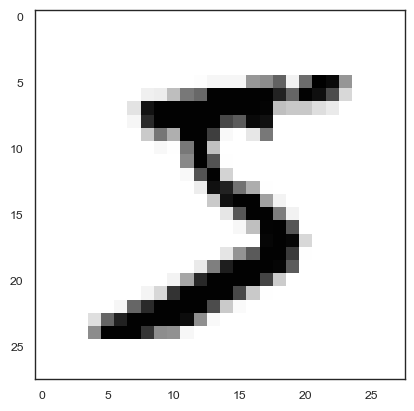

In [10]:
def plot(data,instance):
    plt.imshow(data.iloc[instance].values.reshape(28,28),cmap="Greys")
    
plot(data,0)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target, stratify=target, random_state=0, 
    train_size=train_ratio*subset_ratio, 
    test_size=(1-train_ratio)*subset_ratio
)

In [12]:
len(X_train)

9450

## Modèle supervisé complet

  + KNN simple 
  + CNN 

In [13]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

model = KNeighborsClassifier(n_neighbors=3)
#model = SVC(kernel="rbf", gamma=0.5, probability=True)


model.fit(X_train,y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_pred,y_test)

print("Accuracy %.3f"%acc)


Accuracy 0.948


In [14]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelSpreading, LabelPropagation

## Modèle self-trained

<Axes: >

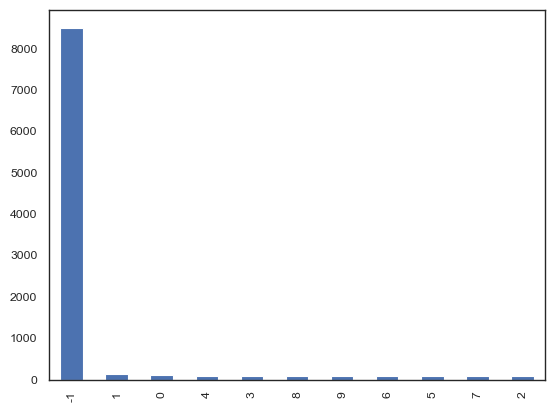

In [15]:
labelled_ratio = 0.1 # combien d'exemples avec labels ? -> 


# le modèle considèrera qu'un label -1 veut dire pas de label
y_labelled = np.copy(y_train)
y_labelled[int(labelled_ratio*len(y_train)):] = -1
counts = pds.Series(y_labelled).value_counts()
counts.plot(kind="bar")

Accuracy 0.868


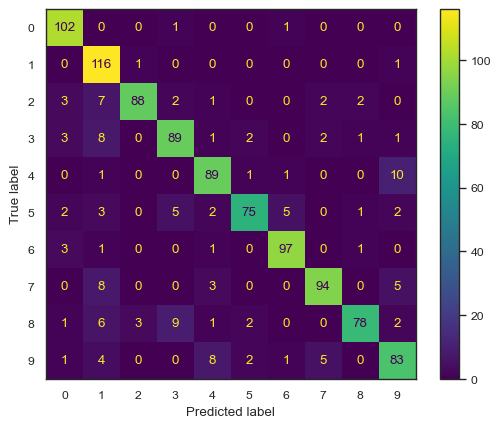

In [16]:
# on compare à entrainement sur la petite base supervisée
model_base = KNeighborsClassifier(n_neighbors=3)
model_base.fit(X_train[y_labelled!=-1],y_labelled[y_labelled!=-1])
y_pred = model_base.predict(X_test)
acc = accuracy_score(y_pred,y_test)

print("Accuracy %.3f"%acc)
cm = confusion_matrix(y_test, y_pred, labels=model_base.classes_)


cmplot = ConfusionMatrixDisplay(cm)
cmplot.plot() 

In [41]:
# Quels paramètres seraient la même chose que d'annoter tout le train avec les predictions faites par le modèle ? 
# NB: ici parametres par défaut de la class selftraining
model_base = KNeighborsClassifier(n_neighbors=3)
st = SelfTrainingClassifier(model_base,
                            threshold = 0.75,
                            criterion="threshold",
                            #criterion="k_best",
                            #k_best=10,
                            max_iter=10).fit(X_train,y_labelled)

In [42]:
y_pred = st.predict(X_test)
acc = accuracy_score(y_pred,y_test)

print("Accuracy %.3f"%acc)

Accuracy 0.917


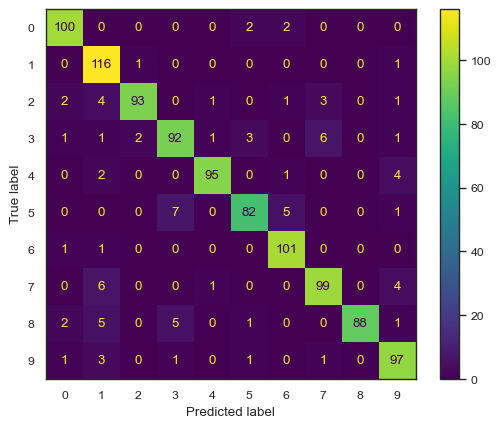

In [43]:
cm = confusion_matrix(y_test, y_pred, labels=st.classes_)


cmplot = ConfusionMatrixDisplay(cm)
cmplot.plot() 

## Propagation de label

In [56]:
ls = LabelSpreading(kernel="knn",alpha=0.2)
ls = LabelPropagation(kernel="knn",n_neighbors=7)
ls.fit(X_train,y_labelled)

LabelPropagation(kernel='knn')

In [57]:
y_pred = ls.predict(X_test)

In [58]:
y_pred

array([9, 1, 8, ..., 1, 5, 4])

In [59]:
acc = accuracy_score(y_pred,y_test)

print("Accuracy %.3f"%acc)

Accuracy 0.905


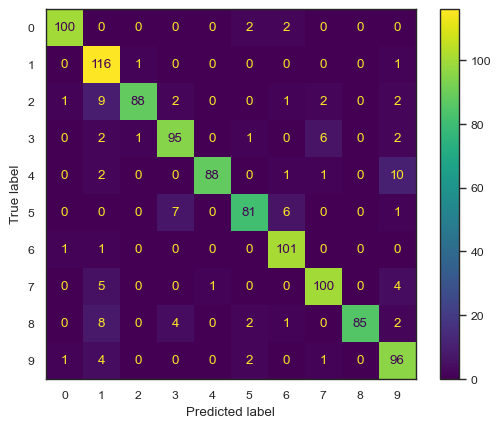

In [48]:
cm = confusion_matrix(y_test, y_pred, labels=ls.classes_)


cmplot = ConfusionMatrixDisplay(cm)
cmplot.plot() 

## Variantes

- Essayer d'améliorer les performances
- Essayer avec LabelPropagation

In [51]:
help(LabelPropagation)

Help on class LabelPropagation in module sklearn.semi_supervised._label_propagation:

class LabelPropagation(BaseLabelPropagation)
 |  LabelPropagation(kernel='rbf', *, gamma=20, n_neighbors=7, max_iter=1000, tol=0.001, n_jobs=None)
 |  
 |  Label Propagation classifier.
 |  
 |  Read more in the :ref:`User Guide <label_propagation>`.
 |  
 |  Parameters
 |  ----------
 |  kernel : {'knn', 'rbf'} or callable, default='rbf'
 |      String identifier for kernel function to use or the kernel function
 |      itself. Only 'rbf' and 'knn' strings are valid inputs. The function
 |      passed should take two inputs, each of shape (n_samples, n_features),
 |      and return a (n_samples, n_samples) shaped weight matrix.
 |  
 |  gamma : float, default=20
 |      Parameter for rbf kernel.
 |  
 |  n_neighbors : int, default=7
 |      Parameter for knn kernel which need to be strictly positive.
 |  
 |  max_iter : int, default=1000
 |      Change maximum number of iterations allowed.
 |  
 |  t